## Load Forecasting by SARIMA method

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [55]:
data = pd.read_csv('data/load.csv')
data.head()

,date,load
0,10/1/2017 0:00,60.626609
1,10/1/2017 0:15,61.020288
2,10/1/2017 0:30,59.839250
3,10/1/2017 0:45,60.823449
4,10/1/2017 1:00,57.477175


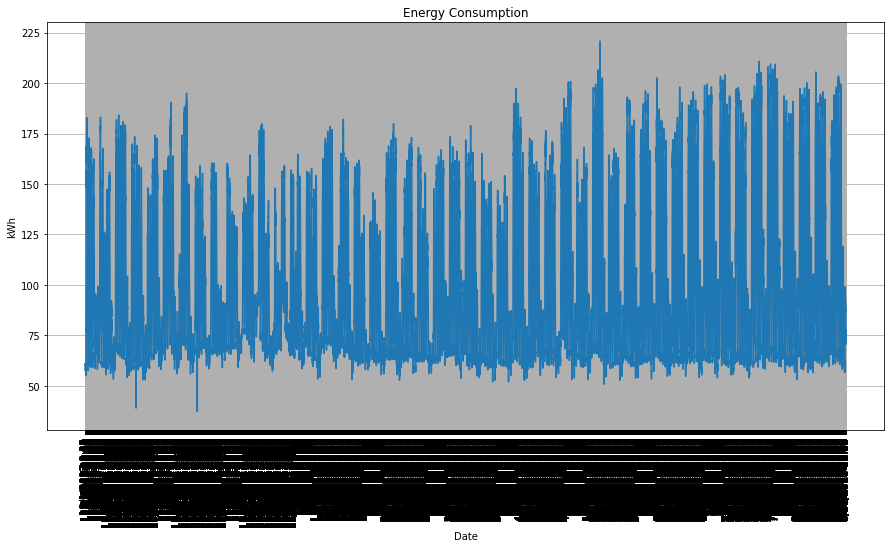

In [3]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'], data['load'])
plt.title('Energy Consumption')
plt.ylabel('kWh')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [4]:
##  test for stationarity with the Augmented Dickey-Fuller test:

ad_fuller_result = adfuller(data['load'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -13.384020348454275
p-value: 4.9136541978100245e-25


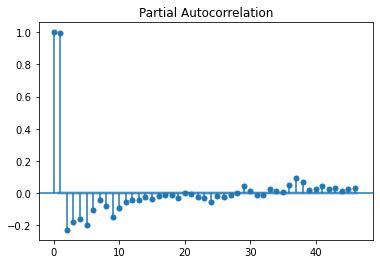

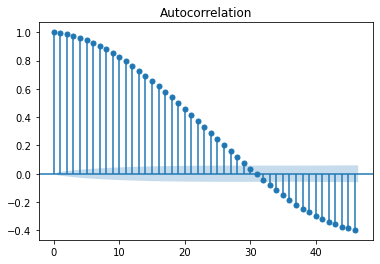

In [5]:
plot_pacf(data['load']);
plot_acf(data['load']);

- We have the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots for the given time-series data.
- While the ACF shows a gradual decrease, the PACF cuts off after 2 lags. Therefore, AR(2) model would be good estimate.

In [6]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [29]:
p = range(0, 3, 1)
d = 0
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [30]:
result_df = optimize_SARIMA(parameters_list, 1, 0, 7, data['load'])
result_df

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 0, 2)",179465.181580
1,"(2, 2, 2, 0)",179472.227407
2,"(2, 2, 0, 1)",179482.027395
3,"(2, 2, 1, 2)",179484.712208
4,"(2, 2, 1, 1)",179493.806789
...,...,...
76,"(0, 0, 1, 1)",185582.787093
77,"(0, 1, 0, 0)",185605.610552
78,"(0, 0, 1, 0)",185737.182947
79,"(0, 0, 0, 1)",185916.226887


In [7]:
best_model = SARIMAX(data['load'], order=(2, 1, 2), seasonal_order=(0, 1, 2, 7)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              load   No. Observations:                32160
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood              -90931.051
Date:                           Sun, 24 Jan 2021   AIC                         181876.102
Time:                                   20:55:30   BIC                         181934.749
Sample:                                        0   HQIC                        181894.858
                                         - 32160                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0751      0.043      1.751      0.080      -0.009       0.159
ar.L2          0.8203      0.040     20.399

best performing model has both seasonal and non-seasonal moving average processes.
From the summary above, you can find the value of the coefficients and their p-value. Notice that from the p-value, all coefficients are significant.

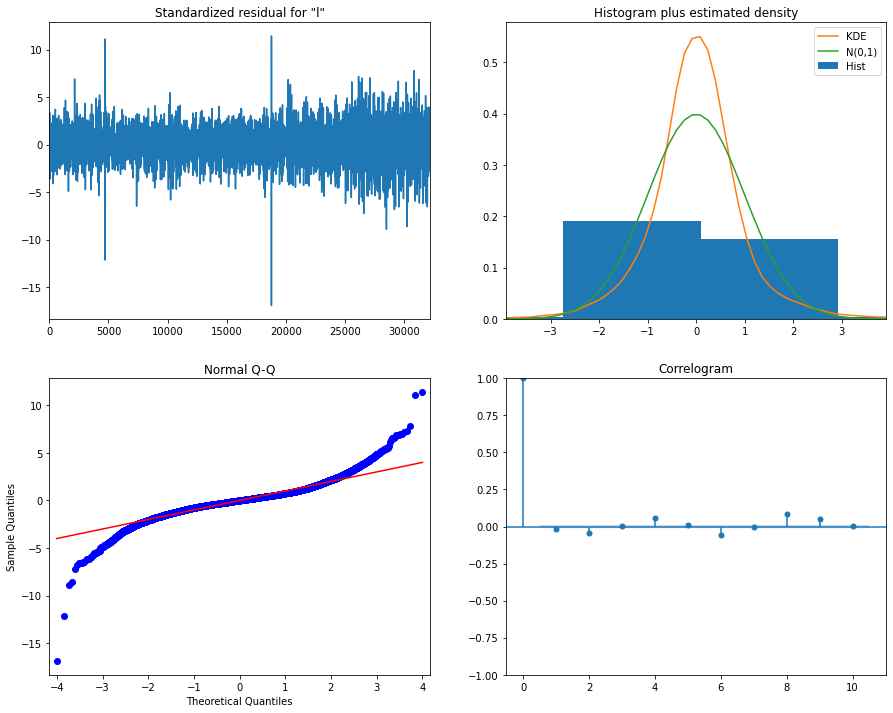

In [8]:
best_model.plot_diagnostics(figsize=(15,12));

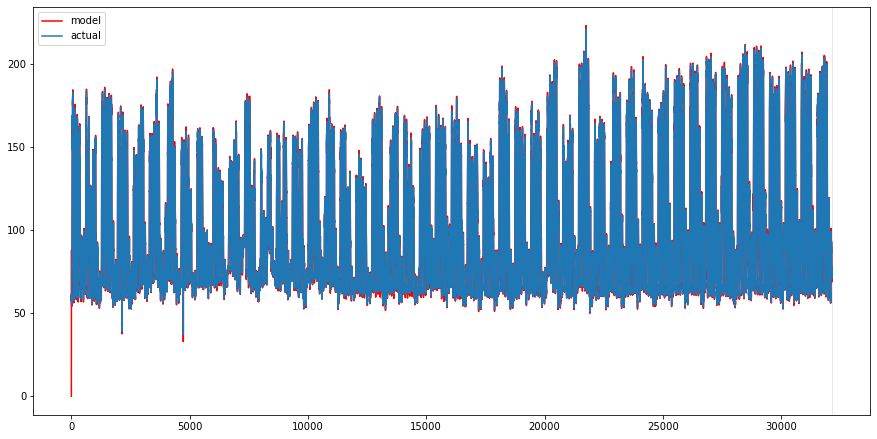

In [9]:
data['arima_model'] = best_model.fittedvalues
# data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0]) ### Change forecasting horizon/window
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['load'], label='actual')
plt.legend()
plt.show()

In [10]:
forecast = forecast.drop(0,)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(data.load, forecast))
print(rms)

1.6911492107614456


In [12]:
### defining Mean Absolute Percentage Error as an additional error index ###

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
mean_absolute_percentage_error(data.load, forecast)

1.1833571369760207

## Analysis

- The RMSE is 1.69 and MAPE is 1.18%, which is significanlty lower than part 1. Therefore, it is important to pick the right parameters when performing seasonal ARIMA.

- Making this a multi-variate analysis with weather variables will make the performance much better.

- Also, profiling for holidays, weekends etc might help in creating and analyzing electric load profiles better.

- Below is the analysis of 24 hour ahead forecast
- I have used the same model parameters as in long term forecasting.

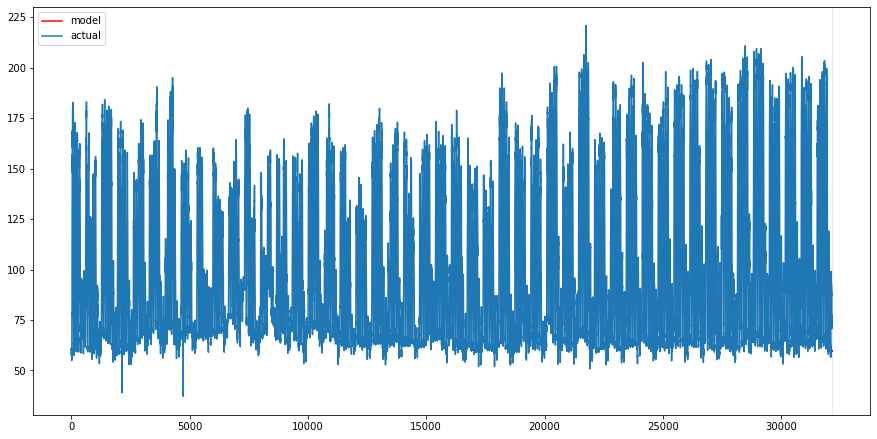

In [31]:
data['arima_model'] = best_model.fittedvalues
# data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=32064, end = 32160, dynamic = True) ### Change forecasting horizon/window
# forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['load'], label='actual')
plt.legend()
plt.show()

In [62]:
original_24hour = data.iloc[32064:]
original = original_24hour.load

In [60]:
predicted = forecast[1:97]

In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(original, predicted))
print(rms)

21.58996039112522


In [64]:
mean_absolute_percentage_error(original, predicted)

19.62799705025081